In [1]:
#%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import math, gillespy2
from gillespy2.solvers.cpp.ssa_c_solver import SSACSolver
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver
from scipy import stats

In [2]:
class DayModel(gillespy2.Model):
    def __init__(self, parameter_values=None, init_v=0, spore=1.61e9, macrophage=1e6):
        # initialize
        gillespy2.Model.__init__(self, name="Macrophage")
        
        ###########
        # species #
        ###########
        #S_ = gillespy2.Species(name='S_', initial_value=3.256e6) # low = 4e3; mid = 2e4; high = 1e7
        S = gillespy2.Species(name='S', initial_value=spore) # low = 4e3; mid = 2e4; high = 1e7
        
        #A_ = gillespy2.Species(name='A_', initial_value=1e6) # A = Sa/(k2*S+MuA)
        A = gillespy2.Species(name='A', initial_value=macrophage) # A = Sa/(k2*S+MuA)
        
        H1 = gillespy2.Species(name='H1', initial_value=0)
        H2 = gillespy2.Species(name='H2', initial_value=0)
        H3 = gillespy2.Species(name='H3', initial_value=0)
        H4 = gillespy2.Species(name='H4', initial_value=0)
        H5 = gillespy2.Species(name='H5', initial_value=0)
        H6 = gillespy2.Species(name='H6', initial_value=0)
        
        HLN1 = gillespy2.Species(name='HLN1', initial_value=0)
        HLN2 = gillespy2.Species(name='HLN2', initial_value=0)
        HLN3 = gillespy2.Species(name='HLN3', initial_value=0)
        HLN4 = gillespy2.Species(name='HLN4', initial_value=0)
        HLN5 = gillespy2.Species(name='HLN5', initial_value=0)
        HLN6 = gillespy2.Species(name='HLN6', initial_value=0)
        
        Be = gillespy2.Species(name='Be', initial_value=0)
        E = gillespy2.Species(name='E', initial_value=2e9)
        N = gillespy2.Species(name='N', initial_value=0)
        Ta = gillespy2.Species(name='Ta', initial_value=0)
        
        self.add_species([S,A,H1,H2,H3,H4,H5,H6,HLN1,HLN2,HLN3,HLN4,HLN5,HLN6,Be,E,N,Ta])
        
        ##############
        # parameters #
        ##############
        #
        k1 = gillespy2.Parameter(name='k1', expression=1e-5)
        
        # rate of phagocytosis
        k2 = gillespy2.Parameter(name='k2', expression=1e-10)
        
        # migration to TMLN
        k3 = gillespy2.Parameter(name='k3', expression=0.05)
        
        #
        k4 = gillespy2.Parameter(name='k4', expression=2)
        
        # Growth rate of extracellular bacteria
        k5 = gillespy2.Parameter(name='k5', expression=0.8)
        
        #
        k6 = gillespy2.Parameter(name='k6', expression=5e-10)
        
        #
        k8 = gillespy2.Parameter(name='k8', expression=6e-10)
        
        #
        k9 = gillespy2.Parameter(name='k9', expression=5e-10)
        
        #
        k10 = gillespy2.Parameter(name='k10', expression=1e-5)
        
        Sa = gillespy2.Parameter(name='Sa', expression=3e8)
        Se = gillespy2.Parameter(name='Se', expression=1e8)

        MuA = gillespy2.Parameter(name='MuA', expression=0.05)
        MuE = gillespy2.Parameter(name='MuE', expression=0.05)
        MuN = gillespy2.Parameter(name='MuN', expression=0.06)
        MuTa = gillespy2.Parameter(name='MuTa', expression=2)

        N0 = gillespy2.Parameter(name='N0', expression=5500)

        BeMAX = gillespy2.Parameter(name='BeMAX', expression=5e11)

        CT1 = gillespy2.Parameter(name='CT1', expression=1)
        CT2 = gillespy2.Parameter(name='CT2', expression=1)
        CT3 = gillespy2.Parameter(name='CT3', expression=1)
        CTB = gillespy2.Parameter(name='CTB', expression=1000)
        
        self.add_parameter([k1,k2,k3,k4,k5,k6,k8,k9,k10,Sa,Se,MuA,MuE,MuN,MuTa,N0,BeMAX,CT1,CT2,CT3,CTB])
        
        #############
        # reactions #
        #############
        
        ########
        # Lung #
        ########
        # Internalization of spores by phagocytes
        R1 = gillespy2.Reaction(
            name='R1',
            reactants={S:1, A:1},
            products={H1:1},
            rate=k2
        )
        
        R2 = gillespy2.Reaction(
            name='R2',
            reactants={S:1, H1:1},
            products={H2:1},
            rate=k2
        )
        
        R3 = gillespy2.Reaction(
            name='R3',
            reactants={S:1, H2:1},
            products={H3:1},
            rate=k2
        )
        
        R4 = gillespy2.Reaction(
            name='R4',
            reactants={S:1, H3:1},
            products={H4:1},
            rate=k2
        )
        
        R5 = gillespy2.Reaction(
            name='R5',
            reactants={S:1, H4:1},
            products={H5:1},
            rate=k2
        )
        
        R6 = gillespy2.Reaction(
            name='R6',
            reactants={S:1, H5:1},
            products={H6:1},
            rate=k2
        )
        
        ##############
        # Lung->TMLN #
        ##############
        # Migration of H (lung) to HLN (TMLN)
        # -k3*H
        R7 = gillespy2.Reaction(
            name='R7',
            reactants={H1:1},
            products={HLN1:1},
            rate=k3
        )
        
        R8 = gillespy2.Reaction(
            name='R8',
            reactants={H2:1},
            products={HLN2:1},
            rate=k3
        )
        
        R9 = gillespy2.Reaction(
            name='R9',
            reactants={H3:1},
            products={HLN3:1},
            rate=k3
        )
        
        R10 = gillespy2.Reaction(
            name='R10',
            reactants={H4:1},
            products={HLN4:1},
            rate=k3
        )
        
        R11 = gillespy2.Reaction(
            name='R11',
            reactants={H5:1},
            products={HLN5:1},
            rate=k3
        )
        
        R12 = gillespy2.Reaction(
            name='R12',
            reactants={H6:1},
            products={HLN6:1},
            rate=k3
        )
        
        ##########################
        # extracellular bacteria #
        ##########################
        # Gain from germinated spores/vegitative bacteria released from host
        # k3*nb*H
        R13 = gillespy2.Reaction(
            name='R13',
            reactants={HLN1:1},
            products={Be:5},
            rate=k3
        )
        
        R14 = gillespy2.Reaction(
            name='R14',
            reactants={HLN2:1},
            products={Be:5},
            rate=k3
        )
        
        R15 = gillespy2.Reaction(
            name='R15',
            reactants={HLN3:1},
            products={Be:5},
            rate=k3
        )
        
        R16 = gillespy2.Reaction(
            name='R16',
            reactants={HLN4:1},
            products={Be:5},
            rate=k3
        )
        
        R17 = gillespy2.Reaction(
            name='R17',
            reactants={HLN5:1},
            products={Be:6},
            rate=k3
        )
        
        R18 = gillespy2.Reaction(
            name='R18',
            reactants={HLN6:1},
            products={Be:7},
            rate=k3
        )
        
        # Extracellular bacterial growth
        # k5*Be*(1 - Be/BeMAX)
        R19 = gillespy2.Reaction(
            name='R19',
            reactants={Be:1},
            products={Be:2},
            propensity_function="k5*Be*(1 - (Be/BeMAX))"
        )
        
        # Killing of Be by early immune response in TMLN
        # -k6*E*Be
        R20 = gillespy2.Reaction(
            name='R20',
            reactants={E:1,Be:1},
            products={},
            rate=k6
        )
        
        # Killing of Be by N; inhibited by toxin
        # k8*N*Be / (1 + (T/CT1))
        R21 = gillespy2.Reaction(
            name='R21',
            reactants={N:1,Be:1},
            products={},
            propensity_function="(k8*N*Be)/(1+(Ta/CT1))"
        )

        ###############
        # Lymphocytes #
        ###############
        # Source of lymphocytes
        # Se
        R22 = gillespy2.Reaction(
            name='R22',
            reactants={},
            products={E:1},
            rate=Se
        )
        
        # Natural Turnover
        # -MuE * E
        R23 = gillespy2.Reaction(
            name='R23',
            reactants={E:1},
            products={},
            rate=MuE
        )
        
        # Bacterial/toxin induced decay
        # -k1 * Be * E
        R24 = gillespy2.Reaction(
            name='R24',
            reactants={E:1,Be:1},
            products={},
            rate=k1
        )
        
        ###############
        # Neutrophils #
        ###############
        # Recruitment/priming by signals from dying lymphocytes; inhibited by toxin
        # k9 * Be * E * N0 / (1 + (Ta/CT2))
        R25 = gillespy2.Reaction(
            name='R25',
            reactants={Be:1,E:1},
            products={N:1},
            propensity_function="(k9*Be*E*N0)/(1+(Ta/CT2))"
        )
        
        # Recruitment/priming by primed neutrophils; inhibited by toxin
        # k10 * N * N0 / (1 + (Ta/CT3))
        R26 = gillespy2.Reaction(
            name='R26',
            reactants={N:1},
            products={N:2},
            propensity_function="(k10*N*N0)/(1+(Ta/CT3))"
        )
        
        # Natural Turnover
        # -MuN * N
        R27 = gillespy2.Reaction(
            name='R27',
            reactants={N:1},
            products={},
            rate=MuN
        )
        
        #################
        # Anthrax Toxin #
        #################
        # Production of toxin by extracellular bacteria
        # k4 * (Be / (CTB + Be))
        R28 = gillespy2.Reaction(
            name='R28',
            reactants={Be:1},
            products={Ta:1},
            propensity_function="k4*(Be/(CTB+Be))"
        )
        
        # Natural Turnover
        # -MuTa * T
        R29 = gillespy2.Reaction(
            name='R29',
            reactants={Ta:1},
            products={},
            rate=MuTa
        )
        
        self.add_reaction([R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,
                           R11,R12,R13,R14,R15,R16,R17,R18,
                           R19,R20,R21,R22,R23,R24,R25,R26,
                           R27,R28,R29])
        t = numpy.linspace(0,200,21)
        self.timespan(t)
        #print(t)

In [3]:
# def get_mean(results):
#     data = []
#     data.extend([1]*int(results['HLN1'][-1]))
#     data.extend([2]*int(results['HLN2'][-1]))
#     data.extend([3]*int(results['HLN3'][-1]))
#     data.extend([4]*int(results['HLN4'][-1]))
#     data.extend([5]*int(results['HLN5'][-1]))
#     data.extend([6]*int(results['HLN6'][-1]))
#     if len(data) != 0:
#         mean = numpy.mean(data)
#     else:
#         mean = 0
#     data=[]
#     return mean

def get_mean(results):
    num =  (
        (1*results['HLN1'][-1]) +
        (2*results['HLN2'][-1]) +
        (3*results['HLN3'][-1]) +
        (4*results['HLN4'][-1]) +
        (5*results['HLN5'][-1]) +
        (6*results['HLN6'][-1])
    )

    div = (
        results['HLN1'][-1] +
        results['HLN2'][-1] +
        results['HLN3'][-1] +
        results['HLN4'][-1] +
        results['HLN5'][-1] +
        results['HLN6'][-1]
    )
    
    weighted_avg = num / div
    return weighted_avg

def get_std(results):
    num =  (
        (1*results['HLN1'][-1]) +
        (2*results['HLN2'][-1]) +
        (3*results['HLN3'][-1]) +
        (4*results['HLN4'][-1]) +
        (5*results['HLN5'][-1]) +
        (6*results['HLN6'][-1])
    )
    
    num_sq =  (
        (1*results['HLN1'][-1]) +
        (4*results['HLN2'][-1]) +
        (9*results['HLN3'][-1]) +
        (16*results['HLN4'][-1]) +
        (25*results['HLN5'][-1]) +
        (36*results['HLN6'][-1])
    )

    div = (
        results['HLN1'][-1] +
        results['HLN2'][-1] +
        results['HLN3'][-1] +
        results['HLN4'][-1] +
        results['HLN5'][-1] +
        results['HLN6'][-1]
    )
    
    weighted_avg = num / div
    var_x = (num_sq / div) - weighted_avg**2
    return numpy.sqrt(var_x)

def get_sem(results):
    n = (
        results['HLN1'][-1] +
        results['HLN2'][-1] +
        results['HLN3'][-1] +
        results['HLN4'][-1] +
        results['HLN5'][-1] +
        results['HLN6'][-1]
    )
    return get_std(results)/numpy.sqrt(n)

def get_levels(results, species):
    levels = results[species][-1]
    return levels

In [4]:
model = DayModel(macrophage=1e6, spore=1e7)
%time results_orig = model.run(solver=BasicODESolver, max_steps=50000000)
#%time results_orig = model.run(solver=SSACSolver)

#%time mean_of_model = get_mean(results_orig[0])
#levels = get_levels(results_orig[0], 'Be')
#mean_of_model
#print("Final extracellular bacteria levels: {0:1.2e}".format(levels))

Wall time: 277 ms


In [5]:
%%time
Be_results = numpy.zeros((20,20))
#sporescale = numpy.logspace(18.75, 20, 20)
#macroscale = numpy.logspace(18, 22, 20)

# spore-macro values for Be heatmap
sporescale = numpy.logspace(3, 7, 20)
macroscale = numpy.logspace(5, 6, 20)


for i,s in enumerate(sporescale):
    for j,a in enumerate(macroscale):
        model = DayModel(spore=s, macrophage=a)
        r = model.run(solver=BasicODESolver, max_steps=50000000)
        Be_results[i,j] = get_levels(r[0], 'Be')

Wall time: 1min 21s


[0, 20, 0, 20]

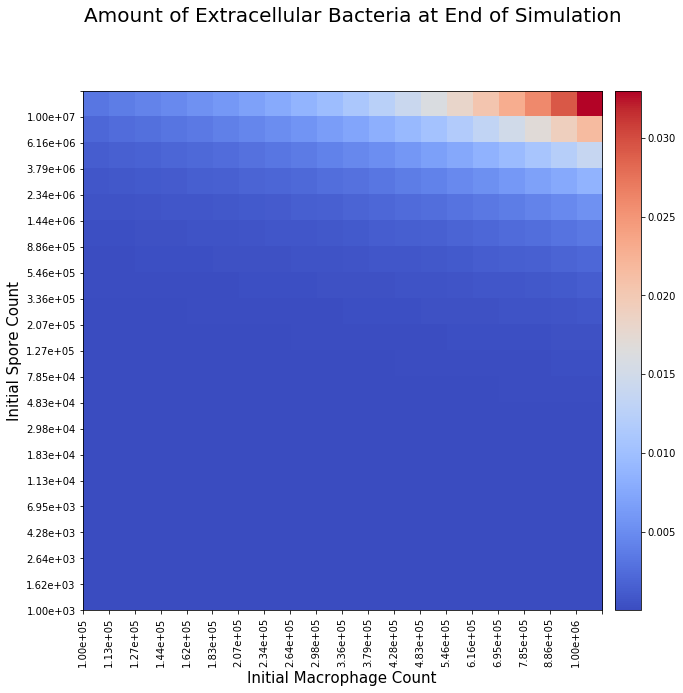

In [6]:
######################################
# HEATMAP FOR EXTRACELLULAR BACTERIA #
######################################
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

x_scale = ['{:.2e}'.format(item) for item in macroscale]
y_scale = ['{:.2e}'.format(item) for item in sporescale]

#fig = plt.figure(figsize=(10,10))
fig,ax = plt.subplots(figsize=(10,10))
fig.suptitle("Amount of Extracellular Bacteria at End of Simulation", fontsize=20)
im = plt.imshow(Be_results, cmap='coolwarm', interpolation='nearest', extent=[0,20,20,0])

#plt.colorbar()
add_colorbar(im)
plt.xlabel("Initial Macrophage Count", fontsize=15)
plt.ylabel("Initial Spore Count", fontsize=15)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    
ticks = numpy.linspace(0,20,21)

plt.xticks(ticks, x_scale, rotation=90)
plt.yticks(ticks, y_scale)
ax.axis([0, 20, 0, 20])

# using log scale doesn't work right
# ax.loglog()
# ax.set_ylim(1e1, 1e9)
# ax.set_xlim(1e1, 1e9)

# print("Spores @ 10: {0:1.2e}".format(sporescale[11]))
# print("Spores @ 20: {0:1.2e}".format(sporescale[19]))
# print("")
# print("Macrophages @ 10: {0:1.2e}".format(macscale[11]))
# print("Macrophages @ 20: {0:1.2e}".format(macscale[19]))

# print("{0:1.2e}".format(sporescale[8]))
# print("{0:1.2e}".format(macscale[8]))
# print(sporescale)
# print(macroscale)
# print("")

# with np.printoptions(formatter={'float': '{: 0.2f}'.format}):
#     i = len(Be_results)-1
#     for r in reversed(Be_results):
#         print('{0}: {1}'.format(i,r)) # use the y-axis from the bottom
#         i=i-1
        


Initial spores: 10000000.0
Spores remaining: 9817049.173479775


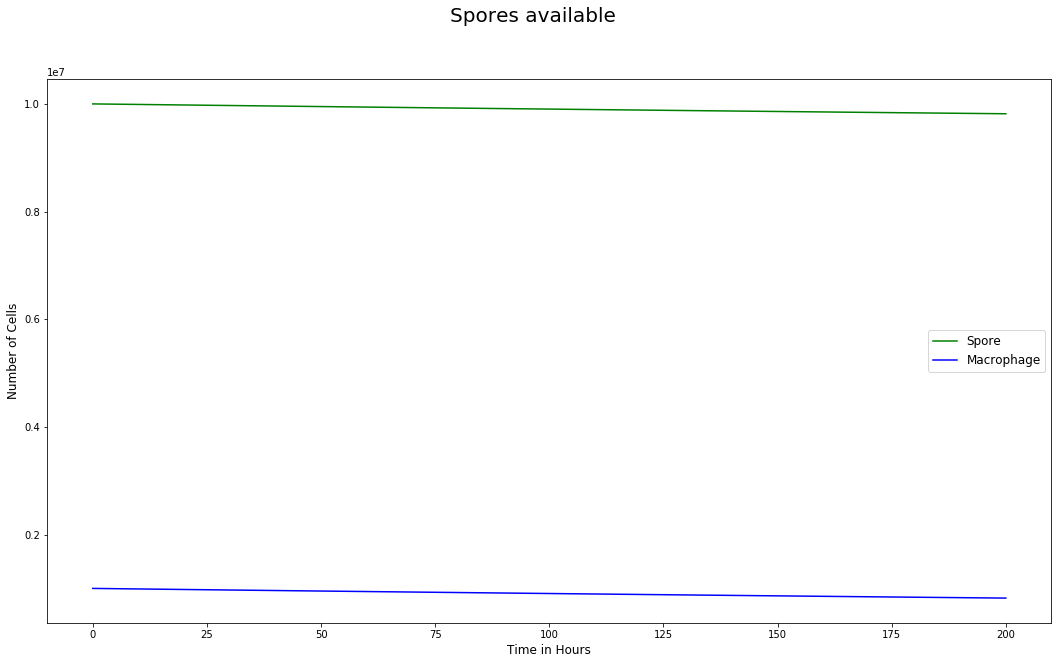

In [13]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores available", fontsize=20)

plt.plot(results_orig[0]['time'], results_orig[0]['S'], 'g-', label='Spore')
plt.plot(results_orig[0]['time'], results_orig[0]['A'], 'b-', label='Macrophage')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
print("Initial spores: {}".format(results_orig[0]['S'][0]))
print("Spores remaining: {}".format(results_orig[0]['S'][-1]))
# print("Spores at 5 hours: {}".format(results['S'][100]))


Lung Hosts at end:
H1: 16132.286162474316
H2: 317.69090443468997
H3: 6.2556377557996905
H4: 0.12272152236345579
H5: 0.0023828499096388662
H6: 4.623172011752583e-05


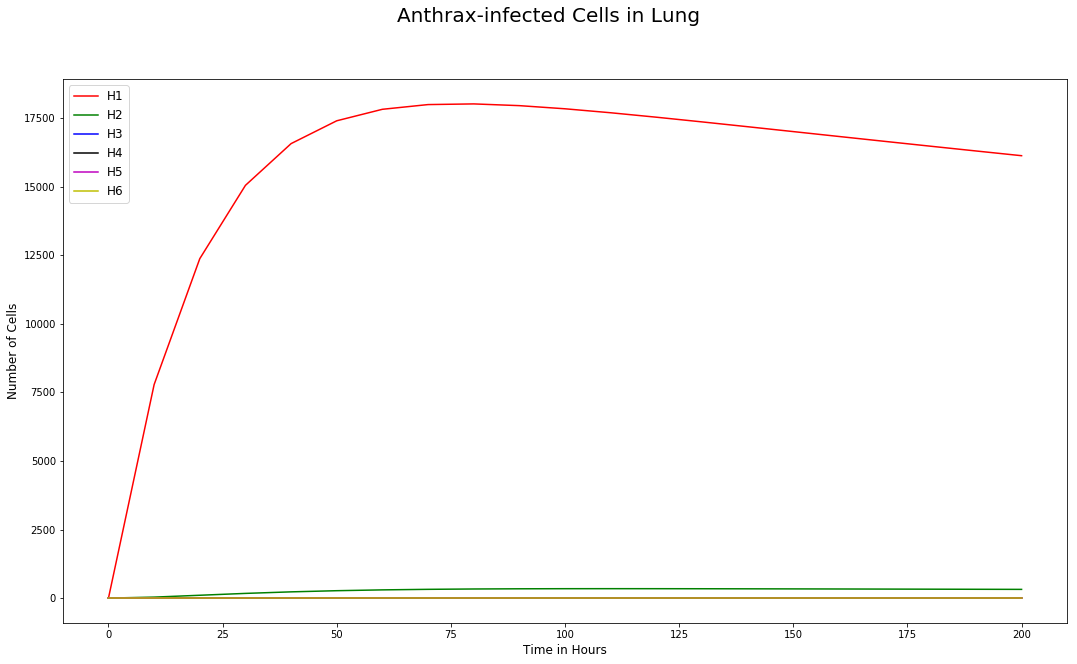

In [8]:
res = results_orig[0]
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S'], 'g-', label='Spore')
plt.plot(res['time'], res['H1'], 'r-', label='H1')
plt.plot(res['time'], res['H2'], 'g-', label='H2')
plt.plot(res['time'], res['H3'], 'b-', label='H3')
plt.plot(res['time'], res['H4'], 'k-', label='H4')
plt.plot(res['time'], res['H5'], 'm-', label='H5')
plt.plot(res['time'], res['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("Lung Hosts at end:")
print("H1: {}".format(res['H1'][-1]))
print("H2: {}".format(res['H2'][-1]))
print("H3: {}".format(res['H3'][-1]))
print("H4: {}".format(res['H4'][-1]))
print("H5: {}".format(res['H5'][-1]))
print("H6: {}".format(res['H6'][-1]))




k2 = 1.00e-10, k3 = 5.00e-02
Lung Hosts at end:
H1: 16132.286162474316
H2: 317.69090443468997
H3: 6.2556377557996905
H4: 0.12272152236345579
H5: 0.0023828499096388662
H6: 4.623172011752583e-05
Lymph Node Hosts at end:
HLN1: 16476.8261641043
HLN2: 324.42178965255687
HLN3: 6.363221217947771
HLN4: 0.12350980207718544
HLN5: 0.002350832571574001
HLN6: 4.422039869368038e-05


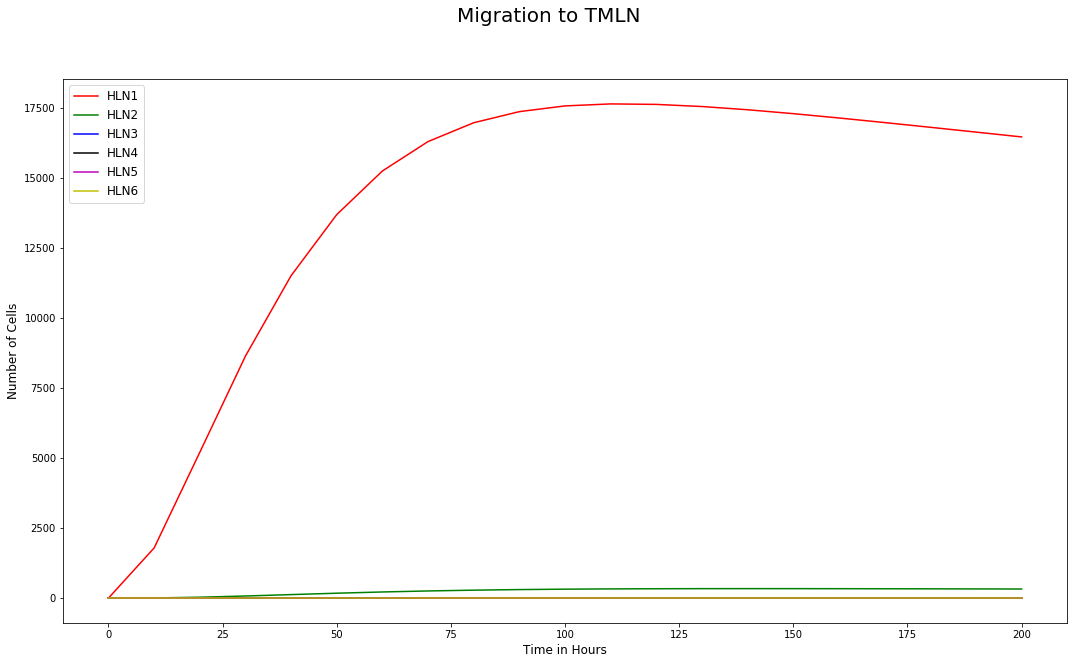

In [9]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)
res = results_orig[0]

#plt.plot(results[0]['time'], results[0]['S'], 'b', label='Spores')
plt.plot(res['time'], res['HLN1'], 'r-', label='HLN1')
plt.plot(res['time'], res['HLN2'], 'g-', label='HLN2')
plt.plot(res['time'], res['HLN3'], 'b-', label='HLN3')
plt.plot(res['time'], res['HLN4'], 'k-', label='HLN4')
plt.plot(res['time'], res['HLN5'], 'm-', label='HLN5')
plt.plot(res['time'], res['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("k2 = {:.2e}, k3 = {:.2e}".format(float(model.listOfParameters['k2'].expression), float(model.listOfParameters['k3'].expression)))

print("Lung Hosts at end:")
print("H1: {}".format(res['H1'][-1]))
print("H2: {}".format(res['H2'][-1]))
print("H3: {}".format(res['H3'][-1]))
print("H4: {}".format(res['H4'][-1]))
print("H5: {}".format(res['H5'][-1]))
print("H6: {}".format(res['H6'][-1]))

print("Lymph Node Hosts at end:")
print("HLN1: {}".format(res['HLN1'][-1]))
print("HLN2: {}".format(res['HLN2'][-1]))
print("HLN3: {}".format(res['HLN3'][-1]))
print("HLN4: {}".format(res['HLN4'][-1]))
print("HLN5: {}".format(res['HLN5'][-1]))
print("HLN6: {}".format(res['HLN6'][-1]))

Lymphocyte Cells: 1999982869.0746768


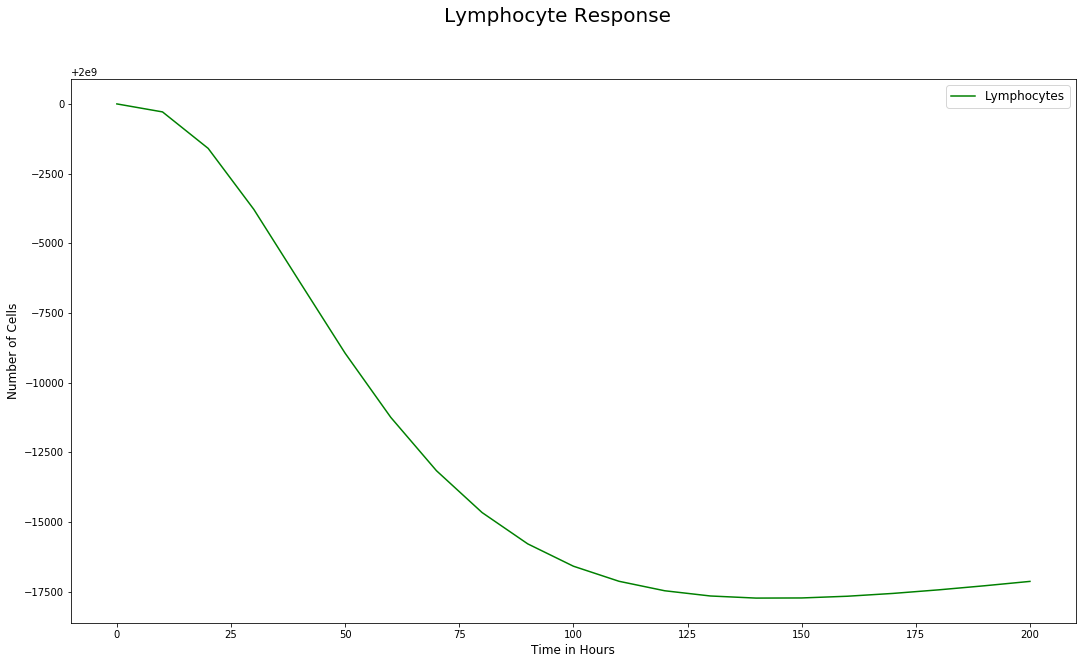

In [15]:
res = results_orig[0]
fig = plt.figure(figsize=(18,10))
fig.suptitle("Lymphocyte Response", fontsize=20)

plt.plot(res['time'], res['E'], 'g-', label='Lymphocytes')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Lymphocyte Cells: {}".format(res['E'][-1]))

0.032955570249968875


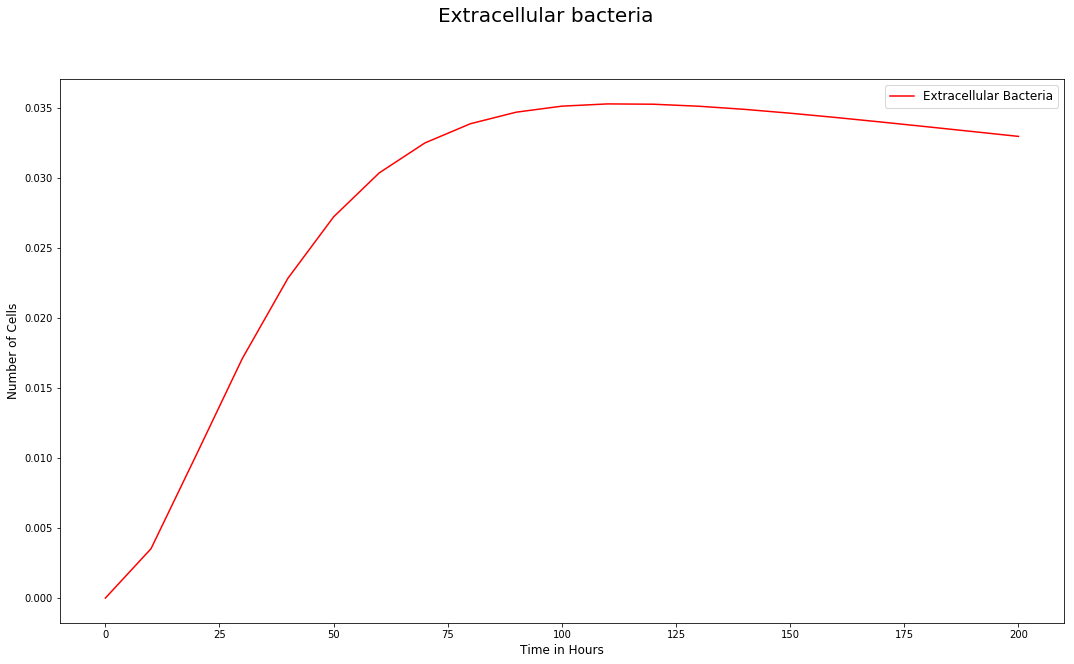

In [10]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Extracellular bacteria", fontsize=20)
res = results_orig[0]

#plt.plot(results[0]['time'], results[0]['S'], 'b', label='Spores')
plt.plot(res['time'], res['Be'], 'r-', label='Extracellular Bacteria')
print(res['Be'][-1])

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()

Lymphocyte Cells: 3071.205455811157


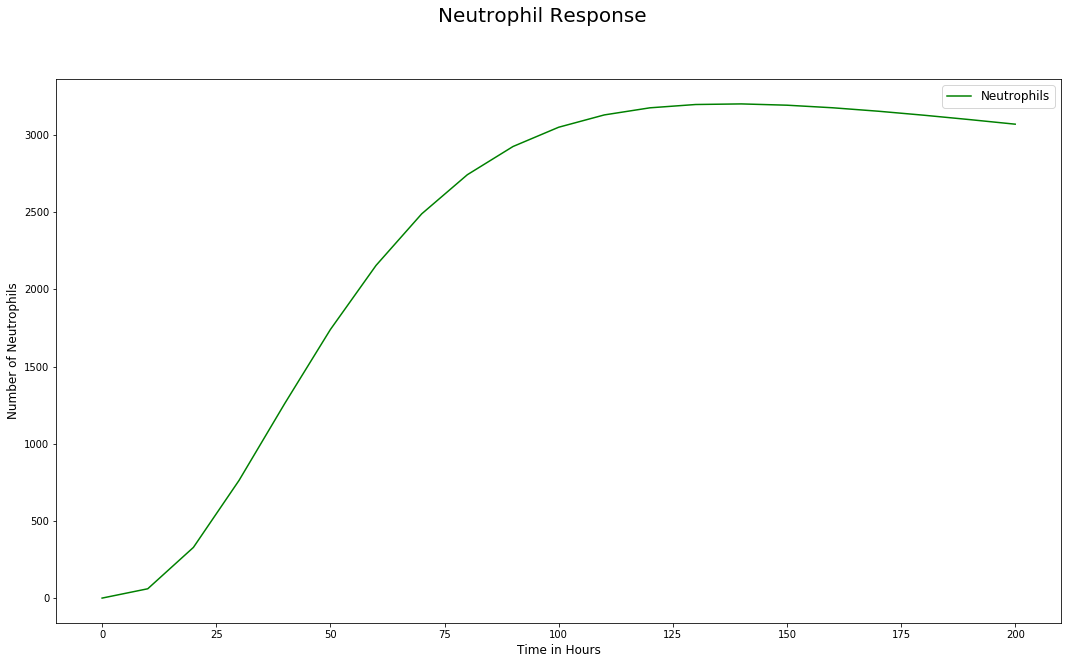

In [17]:
res = results_orig[0]
fig = plt.figure(figsize=(18,10))
fig.suptitle("Neutrophil Response", fontsize=20)

plt.plot(res['time'], res['N'], 'g-', label='Neutrophils')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Neutrophils", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Lymphocyte Cells: {}".format(res['N'][-1]))

Toxins: 3.2971707803732495e-05


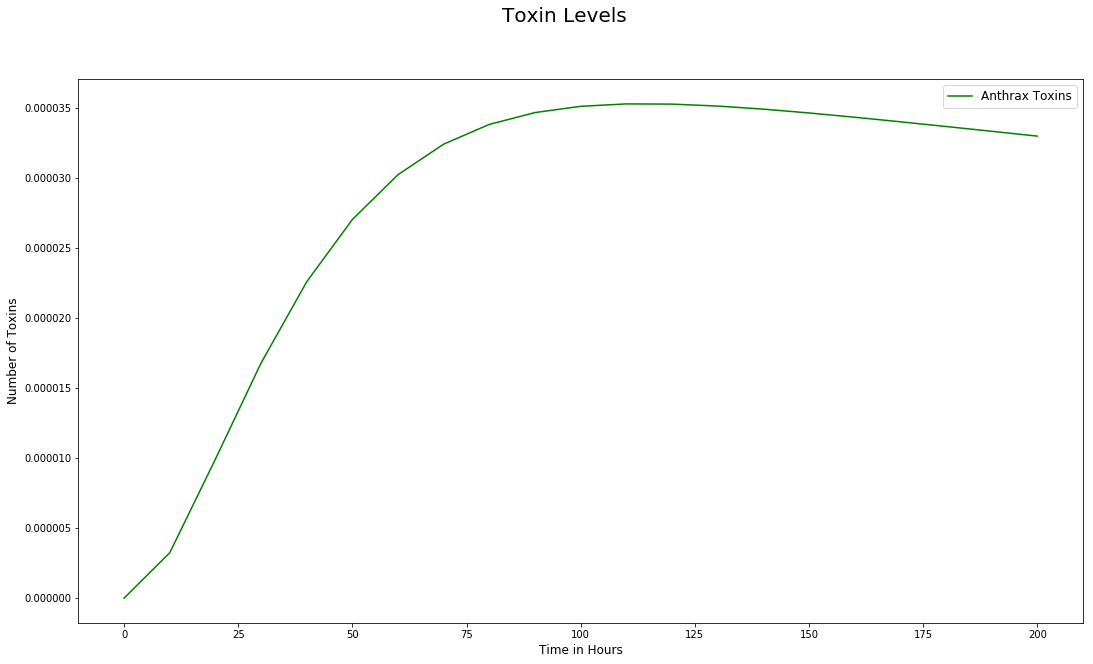

In [19]:
res = results_orig[0]
fig = plt.figure(figsize=(18,10))
fig.suptitle("Toxin Levels", fontsize=20)

plt.plot(res['time'], res['Ta'], 'g-', label='Anthrax Toxins')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Toxins", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Toxins: {}".format(res['Ta'][-1]))